In [1]:
%%capture
%pip install optuna
%pip install pytorch-lightning

In [81]:
from re import I
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset, random_split
from sklearn.model_selection import KFold
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback
import torch.nn.functional as F

In [51]:
BATCHSIZE = 128
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 10
print(f'Training device:', DEVICE)

Training device: cuda


In [52]:
%%capture
test_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transforms.ToTensor())

In [53]:
train_size = 10000
val_size = 2000
test_size = 5000
train_subset = SubsetRandomSampler(np.arange(train_size))
val_subset = SubsetRandomSampler(np.arange(train_size, train_size + val_size))
test_subset = SubsetRandomSampler(np.arange(test_size))

train_dataloader = DataLoader(train_dataset, sampler=train_subset, batch_size=BATCHSIZE, shuffle=False)
val_dataloader = DataLoader(train_dataset, sampler=val_subset, batch_size=BATCHSIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, sampler=test_subset, batch_size=1, shuffle=False)

In [61]:
%%capture
test_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transforms.ToTensor())
full_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [50000, 10000])

In [62]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, sampler=test_subset, batch_size=1, shuffle=False)

In [63]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim=2, dropout=0.5):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_fc = nn.Sequential(
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_fc(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim=2, dropout=0.5):
        super().__init__()

        self.decoder_fc = nn.Sequential(
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=32*3*3),
            nn.Dropout(dropout),
            nn.ReLU(True),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=0, output_padding=0, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, padding=1, output_padding=1, stride=2)
        )

    def forward(self, x):
        x = self.decoder_fc(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [64]:
torch.manual_seed(0)

encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=2, dropout=0)
decoder = Decoder(encoded_space_dim=2, dropout=0)

In [65]:
loss_fn = torch.nn.MSELoss()
lr = 5e-4
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

encoder.to(DEVICE)
decoder.to(DEVICE)

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [66]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.data

def val_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [67]:
num_epochs = 200
train_log = []
val_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    val_loss = val_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    
    train_log.append(train_loss.cpu().numpy())
    val_log.append(val_loss.cpu().numpy())

    print('EPOCH %d/%d: TRAIN - loss: %f || VALIDATION - loss: %f' % (epoch + 1, num_epochs, train_loss, val_loss))

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')

EPOCH 1/200: TRAIN - loss: 0.181567 || VALIDATION - loss: 0.179683
EPOCH 2/200: TRAIN - loss: 0.181771 || VALIDATION - loss: 0.179476
EPOCH 3/200: TRAIN - loss: 0.179809 || VALIDATION - loss: 0.179273
EPOCH 4/200: TRAIN - loss: 0.167219 || VALIDATION - loss: 0.179070
EPOCH 5/200: TRAIN - loss: 0.189991 || VALIDATION - loss: 0.178863
EPOCH 6/200: TRAIN - loss: 0.184687 || VALIDATION - loss: 0.178653
EPOCH 7/200: TRAIN - loss: 0.178610 || VALIDATION - loss: 0.178440
EPOCH 8/200: TRAIN - loss: 0.166723 || VALIDATION - loss: 0.178226
EPOCH 9/200: TRAIN - loss: 0.172707 || VALIDATION - loss: 0.178009
EPOCH 10/200: TRAIN - loss: 0.180971 || VALIDATION - loss: 0.177790
EPOCH 11/200: TRAIN - loss: 0.158641 || VALIDATION - loss: 0.177570
EPOCH 12/200: TRAIN - loss: 0.182073 || VALIDATION - loss: 0.177345
EPOCH 13/200: TRAIN - loss: 0.181966 || VALIDATION - loss: 0.177115
EPOCH 14/200: TRAIN - loss: 0.181705 || VALIDATION - loss: 0.176883
EPOCH 15/200: TRAIN - loss: 0.170606 || VALIDATION - loss

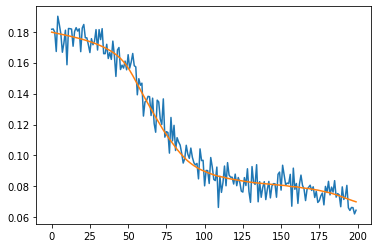

In [68]:
plt.plot(np.array(train_log))
plt.plot(np.array(val_log))

In [69]:
from tqdm import tqdm
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(DEVICE)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples_df = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:06<00:00, 1526.09it/s]


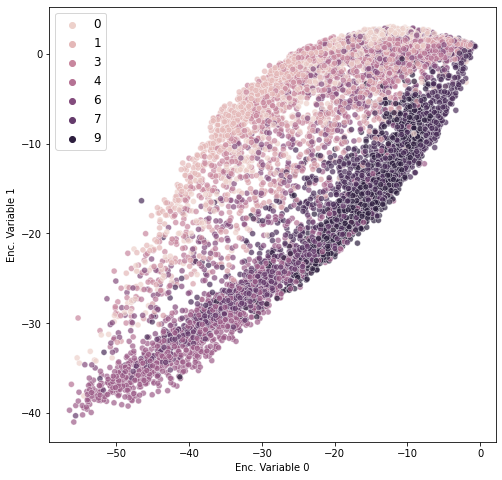

In [85]:
fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)
sns.scatterplot(x='Enc. Variable 0', y='Enc. Variable 1', hue='label', data=encoded_samples_df, ax=ax, alpha=0.7)
ax.legend(fontsize=12)